# Data Mining (CpSc 8650) Course Project  Quality Evaluation of Skull Stripped Brain MRI Images

In [56]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import nibabel as nib
import random
import csv
from scipy import ndimage
import pandas as pd
from tensorflow import keras
import tensorflow.keras.optimizers as optimizers
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# if tf.config.list_physical_devices('GPU'):
#     physical_devices = tf.config.list_physical_devices('GPU')
#     tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#     tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

In [58]:
# !conda create -n my_environment -y
# !source activate my_environment
# !pip install sklearn
# !pip install nibabel
#!wget --no-check-certificate https://dyslexia.computing.clemson.edu/BET_BSE/BET_BSE_DATA.zip

In [59]:
# load and return data 
def load_data(csv_file_path, test_size = 0.3, x_names = [], y_names = []):

    
    """
    Load training data and split it into training and validation set
    """
    print ("Loading data from: ",csv_file_path)
    #reads CSV file into a single dataframe variable
    data_df = pd.read_csv(csv_file_path, names=x_names+y_names, skiprows=1)

    #yay dataframes, we can select rows and columns by their names
    X = data_df[x_names].values
    #and our steering commands as our output data
    y = data_df[y_names ].values

    return X, y

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    print((width_factor, height_factor, depth_factor))
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    print(img.shape)
    return img

def process_scan(path):
#     global i
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    #Resize width, height and depth
    volume = resize_volume(volume)
#     i+=1
#     print(i)
    return volume

In [60]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [0]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, labels):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
#     volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, labels


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



# Get Data

In [61]:
data = load_data(label_file_path, x_names = ["Filename"], y_names = ["Recognizable-Facial-Feature","Brain-Feature-Loss"])

Loading data from:  /home/abastol/DataMining/Project/dataset/Label_file.csv


# Using Train Test Split

In [62]:
# #now we can split the data into a training (80), testing(20), and validation set
# #thanks scikit learn
# test_size = 0.3
# label_file_path = os.path.join(os.path.abspath(os.pardir), "dataset", "Label_file.csv")
# X_train, X_valid, y_train, y_valid = train_test_split(data[0], data[1], test_size=test_size, random_state=0)

# Using K-Fold Cross Validation

In [71]:
next(skf.split(data[0], data[1]))

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multiclass-multioutput' instead.

In [72]:
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits)
print("No.of splits: ", skf.get_n_splits(data[0], data[1]))
print(skf)
StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
for train_index, valid_index in skf.split(data[0], data[1]):
    print("TRAIN:", train_index, "TEST:", valid_index)
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

No.of splits:  4
StratifiedKFold(n_splits=4, random_state=None, shuffle=False)


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multiclass-multioutput' instead.

In [64]:
y_train[y_train=='Yes'] = 1
y_train[y_train=='No'] = 0
y_valid[y_valid=='Yes'] = 1
y_valid[y_valid=='No'] = 0

#### Process Training Data and Testing Data

In [8]:
# os.path.join(os.path.abspath(os.pardir), "dataset", "files", )

In [ ]:
X_data = np.array([process_scan(os.path.join(os.path.abspath(os.pardir), "dataset", "files", path[0]+".gz")) for path in X_valid])

In [9]:
# X_train_data = np.array([process_scan(os.path.join(os.path.abspath(os.pardir), "dataset", "files", path[0]+".gz")) for path in X_train])
# X_valid_data = np.array([process_scan(os.path.join(os.path.abspath(os.pardir), "dataset", "files", path[0]+".gz")) for path in X_valid])

In [10]:
# X_train_valid = [X_train_data, X_valid_data]

In [11]:
outfile = "dataCheckpoints.pkl"

In [12]:
# ## save these objects using pickle
# with open(outfile, "wb") as f:
#     pickle.dump(X_train_valid, f)



In [13]:
#     Load the objects back
with open(outfile, "rb") as f:
    [X_train_data, X_valid_data] = pickle.load(f)

In [14]:
X_train_data.shape

(917, 128, 128, 64)

In [23]:
y_train.shape

(917, 2)

#### Assign 1,0

In [15]:
print(
    "Number of samples in train and validation are %d and %d."
    % (X_train_data.shape[0], X_valid_data.shape[0])
)

Number of samples in train and validation are 917 and 394.


In [16]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train_data,y_train.astype("float32")))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid_data, y_valid.astype("float32")))

batch_size = 24
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train_data))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_valid_data))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

2022-04-07 11:22:39.009374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 11:22:40.232482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2022-04-07 11:22:40.238408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38397 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


## Displaying Image

Dimension of the CT scan is: (128, 128, 64)


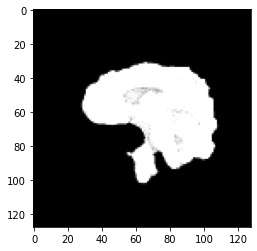

In [17]:

image = X_train_data[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plt.show()

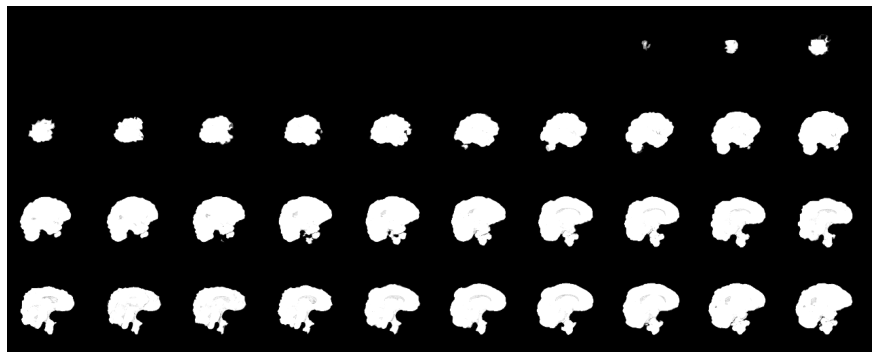

In [18]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [19]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=2, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 16)  448       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 32)    13856     
                                                             

In [22]:
# Compile model.
initial_learning_rate = 0.00001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_relu.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


2022-04-07 11:23:19.338675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-07 11:23:21.713569: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39/39 [==============================] - 13s 203ms/step - loss: 0.7233 - acc: 0.3315 - val_loss: 0.6939 - val_acc: 0.4949
Epoch 2/100
39/39 [==============================] - 7s 184ms/step - loss: 0.6261 - acc: 0.8833 - val_loss: 0.6960 - val_acc: 0.4949
Epoch 3/100
39/39 [==============================] - 7s 184ms/step - loss: 0.5522 - acc: 0.9826 - val_loss: 0.6991 - val_acc: 0.4949
Epoch 4/100
39/39 [==============================] - 7s 184ms/step - loss: 0.4919 - acc: 0.9847 - val_loss: 0.7018 - val_acc: 0.4949
Epoch 5/100
39/39 [==============================] - 7s 185ms/step - loss: 0.4460 - acc: 0.9815 - val_loss: 0.6971 - val_acc: 0.4949
Epoch 6/100
39/39 [==============================] - 7s 186ms/step - loss: 0.4059 - acc: 0.9826 - val_loss: 0.6857 - val_acc: 0.4949
Epoch 7/100
39/39 [==============================] - 7s 184ms/step - loss: 0.3752 - acc: 0.9836 - val_loss: 0.6628 - val_acc: 0.4949
Epoch 8/100
39/39 [==============================] - 8s 196ms/step - loss: 0.348

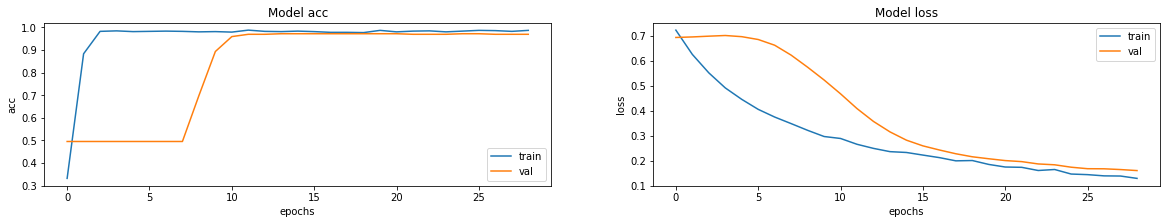

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Predict with a image

In [27]:
file = process_scan('../dataset/files/IXI002-Guys-0828-T1_bse_less_s5_r1.nii.gz')
file = tf.expand_dims(file, axis=0)

prediction = model.predict(file)


# yes,no = prediction[0] * 100, (1-prediction[0]) *100

# print("Yes=",yes[0],"No=",no[0])
# if(yes[0]>50):
#     print("Facial Feature Recognizable")
# else:
#     print("Facial Feature not recognizable")

(0.5, 0.5, 0.4266666666666667)
(128, 128, 64)


In [44]:
prediction[0][0]>0.5


True

In [43]:
prediction[0][1]>0.5

False